# Recommendation System : Game on Steam

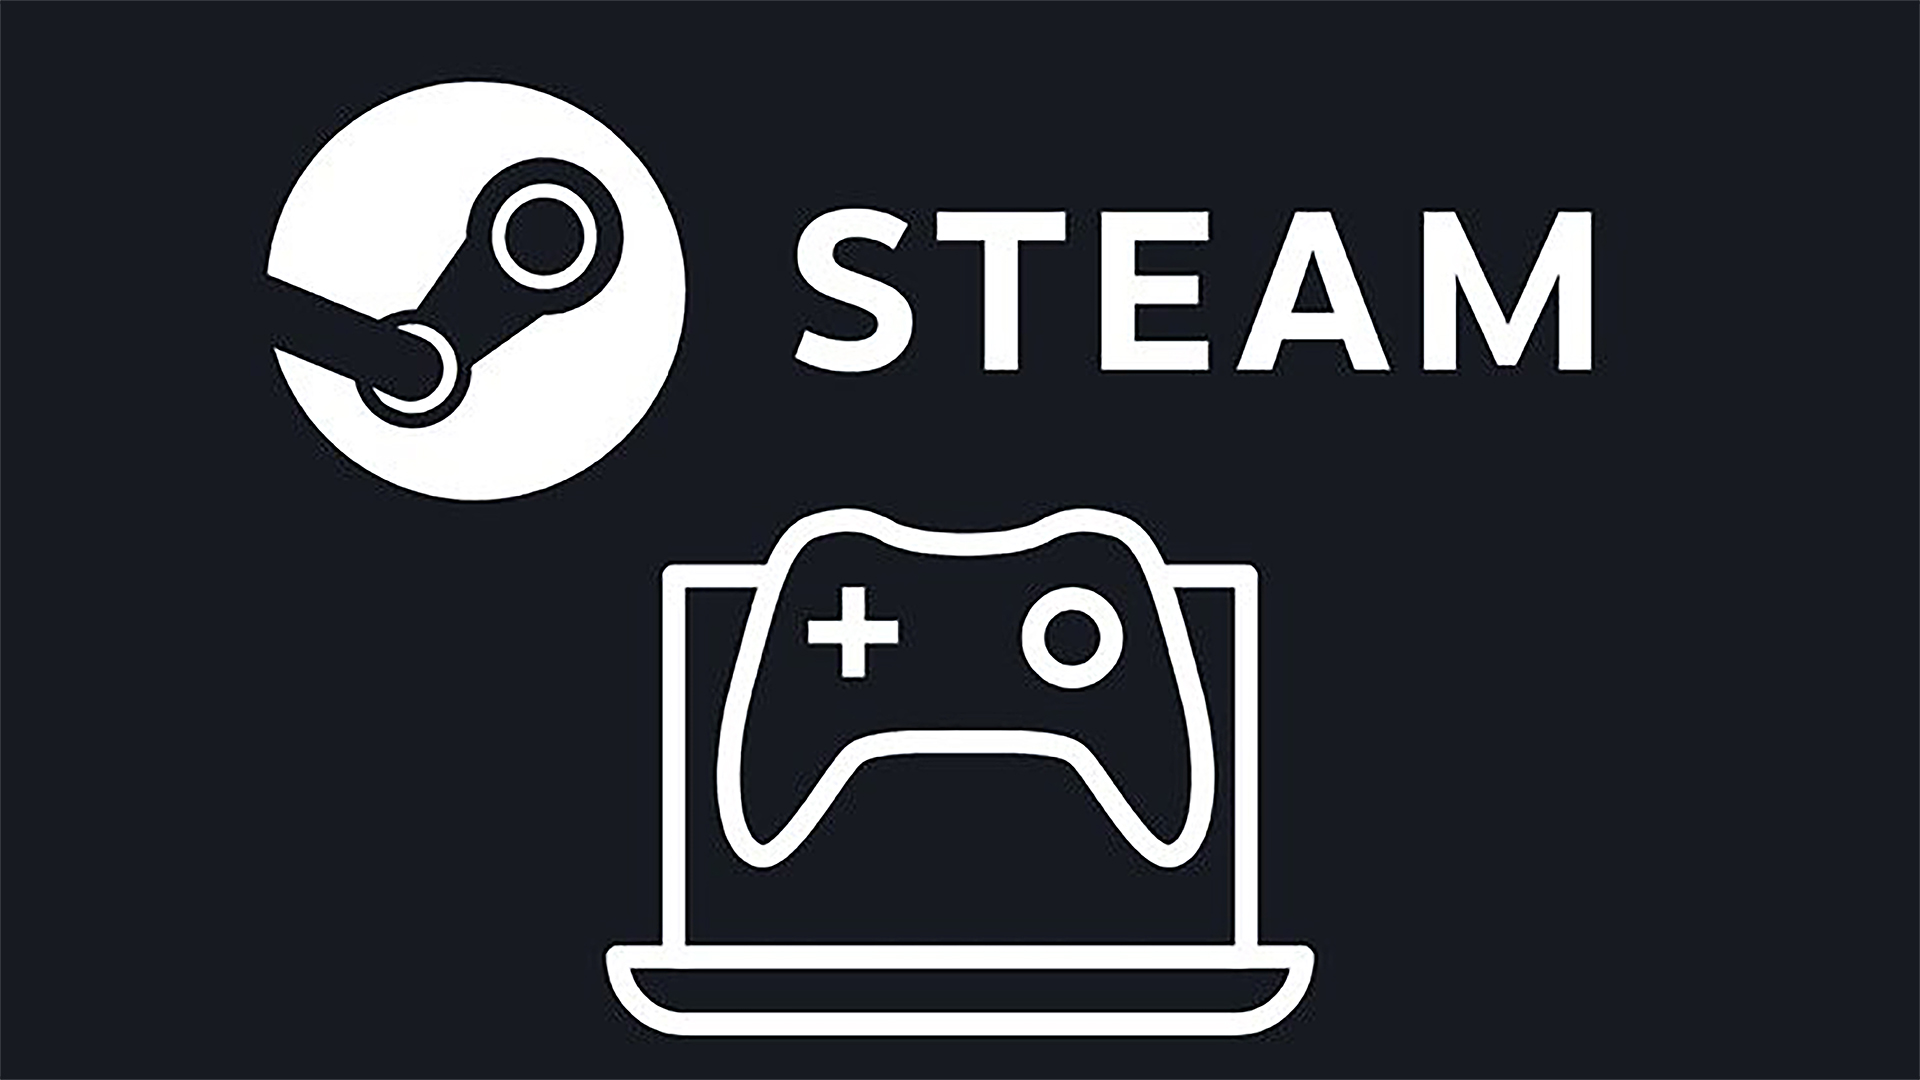

# Mengimpor Library

Pada tahap ini kita akan mengimpor library sesuai kebutuhan seperti numpy, pandas, seaborn dan lainnya.

In [ ]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np
import textwrap
import re
from ast import literal_eval

# Machine Learning dan Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Natural Language Processing
import nltk
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Deep Learning Model Components
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Gathering Data

Pada tahap ini kita akan mengambil data dari [Kaggle](https://www.kaggle.com/datasets), yang berjudul [Game Recommendations on Steam](https://www.kaggle.com/api/v1/datasets/download/antonkozyriev/game-recommendations-on-steam)

In [ ]:
!kaggle datasets download antonkozyriev/game-recommendations-on-steam

Dataset URL: https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam
License(s): CC0-1.0
game-recommendations-on-steam.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/game-recommendations-on-steam.zip -d /content

Archive:  /content/game-recommendations-on-steam.zip
replace /content/games.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#Data Understanding

Tahap Load Dataset adalah proses memuat dataset yang akan digunakan, sehingga mempermudah dalam memahami isi data tersebut.

<br>

**Informasi Datasets**


| Jenis    | Keterangan                                                |
|----------|-----------------------------------------------------------|
| Title    | Game Recommendations on Steam |
| Source   |[Kaggle](https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam) |
| Maintainer | [Anton Kozyriev](https://www.kaggle.com/antonkozyriev) |
| License | Database: Open Database, Contents: Database Contents |
|  | Publik |
| Tags | Tabular, Games, Video Games, Exploratory Data Analysis, Recommender Systems |
|File Available| `games.csv`, `users.csv`, `recommendations.csv`, `games_metadata.json` |
| Usability | 10.00 |



## Arti Variabel

### Dataset Games `games.csv`

| Kolom | Deskripsi |
|-------|-----------|
| app_id | Identifikasi unik untuk setiap game di Steam |
| title | Judul resmi game |
| date_release | Tanggal rilis game |
| win | Menunjukkan apakah game tersedia untuk sistem operasi Windows (true/false) |
| mac | Menunjukkan apakah game tersedia untuk sistem operasi Mac (true/false) |
| linux | Menunjukkan apakah game tersedia untuk sistem operasi Linux (true/false) |
| rating | Peringkat umum game berdasarkan ulasan pengguna |
| positive_ratio | Persentase ulasan positif dari total ulasan |
| user_reviews | Jumlah total ulasan pengguna |
| price_final | Harga akhir game |
| price_original | Harga asli game sebelum diskon |
| discount | Persentase diskon yang diterapkan |
| steam_deck | Menunjukkan apakah game kompatibel dengan Steam Deck (true/false) |


### Dataset Users `users.csv`

| Kolom | Deskripsi |
|-------|-----------|
| user_id | Identifikasi unik untuk setiap pengguna |
| products | Jumlah produk/game yang dimiliki pengguna |
| reviews | Jumlah ulasan yang dibuat pengguna |

### Dataset Recommendations `recommendations.csv`

| Kolom | Deskripsi |
|-------|-----------|
| app_id | Identifikasi game yang direview |
| helpful | Jumlah pengguna yang menganggap review ini membantu |
| funny | Jumlah pengguna yang menganggap review ini lucu |
| date | Tanggal review dibuat |
| is_recommended | Apakah pengguna merekomendasikan game tersebut (True/False) |
| hours | Jumlah jam bermain game |
| user_id | Identifikasi pengguna yang membuat review |
| review_id | Identifikasi unik untuk setiap review |

### Dataset Games Metadata `games_metadata.json`

| Kolom | Deskripsi |
|-------|-----------|
| app_id | Identifikasi unik untuk setiap game |
| description | Deskripsi singkat tentang game |
| tags | Kategori atau label yang menggambarkan karakteristik game |

## Load Dataset

In [ ]:
games = pd.read_csv('/content/games.csv')
users = pd.read_csv('/content/users.csv')
recommendations = pd.read_csv('/content/recommendations.csv')
games_metadata = pd.read_json('/content/games_metadata.json', lines=True)

In [ ]:
games.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


In [ ]:
users.head()

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


In [ ]:
recommendations.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4


In [ ]:
games_metadata.head()

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


## Data Cleaning

### Pengecekan Missing Values

In [ ]:
games.isnull().sum()

,0
app_id,0
title,0
date_release,0
win,0
mac,0
linux,0
rating,0
positive_ratio,0
user_reviews,0
price_final,0


In [ ]:
users.isnull().sum()

,0
user_id,0
products,0
reviews,0


In [ ]:
recommendations.isnull().sum()

,0
app_id,0
helpful,0
funny,0
date,0
is_recommended,0
hours,0
user_id,0
review_id,0


In [ ]:
games_metadata.isnull().sum()

,0
app_id,0
description,0
tags,0


### Pengecekan duplikasi data

In [ ]:
games.duplicated().sum()

0

In [ ]:
users.duplicated().sum()

0

In [ ]:
recommendations.duplicated().sum()


0

### Konversikan `games_metadata` dengan daftar menjadi tuple agar bisa melakukan data cleaning

In [ ]:
# Konversikan kolom dengan daftar menjadi tuple. Tuple bersifat tidak dapat diubah (immutable) dan dapat di-hash.
for col in games_metadata.columns:
    if games_metadata[col].apply(type).eq(list).any():
        games_metadata[col] = games_metadata[col].apply(tuple)

games_metadata.duplicated().sum()

0

### Membuat fungsi untuk konversi type data 64 ke 32

In [ ]:
def reduce_memory(data):
    for col in data.columns:
        if data[col].dtype == 'float64':
            data[col] = data[col].astype('float32')
        elif data[col].dtype == 'int64':
            data[col] = data[col].astype('int32')
    return data

In [ ]:
data_game = reduce_memory(games)

In [ ]:
data_users = reduce_memory(users)

In [ ]:
data_recommendations = reduce_memory(recommendations)

In [ ]:
data_games_metadata = reduce_memory(games_metadata)

### Mengurangi data yang besar

Pada tahap ini kita akan melakukan pengurangan data yang besar agar tidak crash

In [ ]:
sample_recommendations = data_recommendations.sample(frac=0.001, random_state=42)

In [ ]:
sample_recommendations.shape

(41155, 8)

In [ ]:
# Ambil user_id unik dari sample_recommendations
user_ids_in_recommendations = sample_recommendations['user_id'].unique()

# Filter data_users berdasarkan user_id yang ada di sample_recommendations
filtered_data_users = data_users[data_users['user_id'].isin(user_ids_in_recommendations)]

print(f"Jumlah users yang dipertahankan: {filtered_data_users.shape[0]}")

Jumlah users yang dipertahankan: 40771


In [ ]:
# Filter user_id
sample_data_users = data_users[data_users['user_id'].isin(sample_recommendations['user_id'])]

# Filter app_id
sample_recommendations = sample_recommendations[sample_recommendations['app_id'].isin(games['app_id'])]

# Pastikan konsistensi lagi
consistent_recommendations = sample_recommendations[
    sample_recommendations['user_id'].isin(sample_data_users['user_id'])
]

print(f"Final jumlah rekomendasi: {consistent_recommendations.shape[0]}")
print(f"Final jumlah users: {sample_data_users.shape[0]}")


Final jumlah rekomendasi: 41155
Final jumlah users: 40771


In [ ]:
# Cek konsistensi user_id
missing_users = set(consistent_recommendations['user_id']) - set(sample_data_users['user_id'])
print(f"User ID yang ada di consistent_recommendations tapi tidak ada di users: {len(missing_users)}")

# Cek konsistensi app_id
missing_games = set(consistent_recommendations['app_id']) - set(games['app_id'])
print(f"Game ID yang ada di recommendations tapi tidak ada di games: {len(missing_games)}")

User ID yang ada di consistent_recommendations tapi tidak ada di users: 0
Game ID yang ada di recommendations tapi tidak ada di games: 0


### Menggabungkan data games dan metadata games

In [ ]:
final_games = pd.merge(games , games_metadata , on = 'app_id' , how = 'inner')

## Finalisasi Cleaning Data

Di lihat dari isi data di atas sudah balance dan kita akan pengecekan sekali lagi untuk memastikan bahwasanya data ini benar-benar tidak redundan

In [ ]:
final_games.isnull().sum()

,0
app_id,0
title,0
date_release,0
win,0
mac,0
linux,0
rating,0
positive_ratio,0
user_reviews,0
price_final,0


In [ ]:
sample_data_users.isnull().sum()

,0
user_id,0
products,0
reviews,0


In [ ]:
sample_recommendations.isnull().sum()

,0
app_id,0
helpful,0
funny,0
date,0
is_recommended,0
hours,0
user_id,0
review_id,0


In [ ]:
final_games.isna().sum()

,0
app_id,0
title,0
date_release,0
win,0
mac,0
linux,0
rating,0
positive_ratio,0
user_reviews,0
price_final,0


In [ ]:
sample_data_users.isna().sum()

,0
user_id,0
products,0
reviews,0


In [ ]:
sample_recommendations.isna().sum()

,0
app_id,0
helpful,0
funny,0
date,0
is_recommended,0
hours,0
user_id,0
review_id,0


In [ ]:
final_games.isna().sum()

,0
app_id,0
title,0
date_release,0
win,0
mac,0
linux,0
rating,0
positive_ratio,0
user_reviews,0
price_final,0


# Exploratory Data Analysis (EDA)

## ***Exploratory Data Analysis* (EDA)** - Deskripsi Variabel

In [ ]:
final_games.shape

(50872, 15)

In [ ]:
sample_data_users.shape

(40771, 3)

In [ ]:
sample_recommendations.shape

(41155, 8)

In [ ]:
final_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int32  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int32  
 8   user_reviews    50872 non-null  int32  
 9   price_final     50872 non-null  float32
 10  price_original  50872 non-null  float32
 11  discount        50872 non-null  float32
 12  steam_deck      50872 non-null  bool   
 13  description     50872 non-null  object 
 14  tags            50872 non-null  object 
dtypes: bool(4), float32(3), int32(3), object(5)
memory usage: 3.3+ MB


In [ ]:
sample_data_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40771 entries, 114 to 14305789
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   40771 non-null  int32
 1   products  40771 non-null  int32
 2   reviews   40771 non-null  int32
dtypes: int32(3)
memory usage: 796.3 KB


In [ ]:
sample_recommendations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41155 entries, 29073097 to 36665294
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          41155 non-null  int32  
 1   helpful         41155 non-null  int32  
 2   funny           41155 non-null  int32  
 3   date            41155 non-null  object 
 4   is_recommended  41155 non-null  bool   
 5   hours           41155 non-null  float32
 6   user_id         41155 non-null  int32  
 7   review_id       41155 non-null  int32  
dtypes: bool(1), float32(1), int32(5), object(1)
memory usage: 1.6+ MB


In [ ]:
final_games.describe()

,app_id,positive_ratio,user_reviews,price_final,price_original,discount
count,5.087200e+04,50872.000000,5.087200e+04,50872.000000,50872.000000,50872.000000
mean,1.055224e+06,77.052033,1.824425e+03,8.620325,8.726789,5.592212
std,6.103249e+05,18.253592,4.007352e+04,11.514164,11.507022,18.606680
min,1.000000e+01,0.000000,1.000000e+01,0.000000,0.000000,0.000000
25%,5.287375e+05,67.000000,1.900000e+01,0.990000,0.990000,0.000000
50%,9.860850e+05,81.000000,4.900000e+01,4.990000,4.990000,0.000000
75%,1.524895e+06,91.000000,2.060000e+02,10.990000,11.990000,0.000000
max,2.599300e+06,100.000000,7.494460e+06,299.989990,299.989990,90.000000


In [ ]:
sample_data_users.describe()

,user_id,products,reviews
count,4.077100e+04,40771.000000,40771.000000
mean,7.456114e+06,274.087415,20.404601
std,4.014007e+06,626.765730,83.883669
min,5.190000e+02,0.000000,1.000000
25%,4.277404e+06,50.000000,2.000000
50%,7.546667e+06,119.000000,5.000000
75%,1.097968e+07,272.000000,15.000000
max,1.430490e+07,17475.000000,6045.000000


In [ ]:
sample_recommendations.describe()

,app_id,helpful,funny,hours,user_id,review_id
count,4.115500e+04,41155.000000,41155.000000,41155.000000,4.115500e+04,4.115500e+04
mean,6.058296e+05,3.126497,1.252557,99.317589,7.462344e+06,2.064916e+07
std,4.744594e+05,31.300315,26.719086,174.062393,4.013506e+06,1.188722e+07
min,1.000000e+01,0.000000,0.000000,0.000000,5.190000e+02,1.294000e+03
25%,2.547000e+05,0.000000,0.000000,7.600000,4.290241e+06,1.029190e+07
50%,4.381000e+05,0.000000,0.000000,27.000000,7.551315e+06,2.071623e+07
75%,9.453600e+05,0.000000,0.000000,97.199997,1.099428e+07,3.084018e+07
max,2.209610e+06,2483.000000,2535.000000,999.799988,1.430490e+07,4.115428e+07


## ***Exploratory Data Analysis* (EDA)** - *Univariate Analysis*

### 1. Distribusi Platform Game

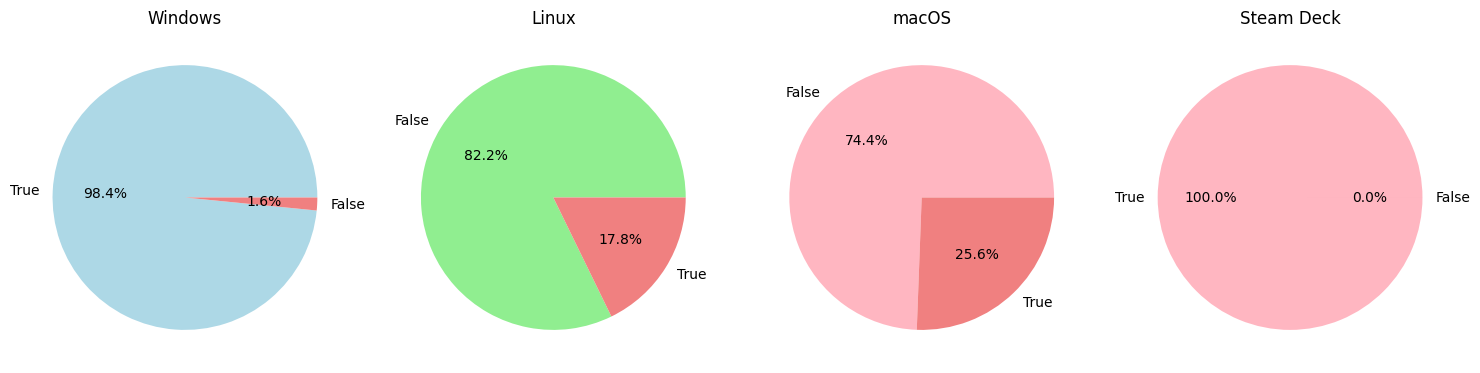

In [ ]:
counts_win = games['win'].value_counts()
counts_linux = games['linux'].value_counts()
counts_mac = games['mac'].value_counts()
counts_steamdeck = games['steam_deck'].value_counts()

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# pie chart for Windows
axs[0].pie(counts_win, labels=counts_win.index, autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
axs[0].set_title('Windows')

# pie chart for Linux
axs[1].pie(counts_linux, labels=counts_linux.index, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
axs[1].set_title('Linux')

# pie chart for macOS
axs[2].pie(counts_mac, labels=counts_mac.index, autopct='%1.1f%%', colors=['lightpink', 'lightcoral'])
axs[2].set_title('macOS')

# pie chart for Steam Deck
axs[3].pie(counts_steamdeck, labels=counts_steamdeck.index, autopct='%1.1f%%', colors=['lightpink', 'lightcoral'])
axs[3].set_title('Steam Deck')
plt.tight_layout()
plt.show()

Gambar tersebut menunjukkan distribusi penggunaan sistem operasi dalam bentuk diagram pie. Berikut interpretasi dari setiap sistem operasi:

1. **Windows**: Sebagian besar pengguna (98.4%) menggunakan Windows, sementara hanya 1.6% yang tidak.
2. **Linux**: 82.2% pengguna tidak menggunakan Linux, sedangkan 17.8% menggunakan Linux.
3. **macOS**: 74.4% pengguna tidak menggunakan macOS, sedangkan 25.6% adalah pengguna macOS.
4. **Steam Deck**: Semua pengguna (100%) menggunakan Steam Deck, tanpa ada yang tidak menggunakannya.

Dari data ini, dapat disimpulkan bahwa Windows memiliki dominasi tertinggi sebagai sistem operasi yang digunakan, sedangkan Steam Deck digunakan oleh semua pengguna yang tercatat dalam data ini. Linux dan macOS memiliki proporsi pengguna yang lebih kecil dibandingkan dengan Windows.

### 2. Distribusi Rasio Ulasan Positif

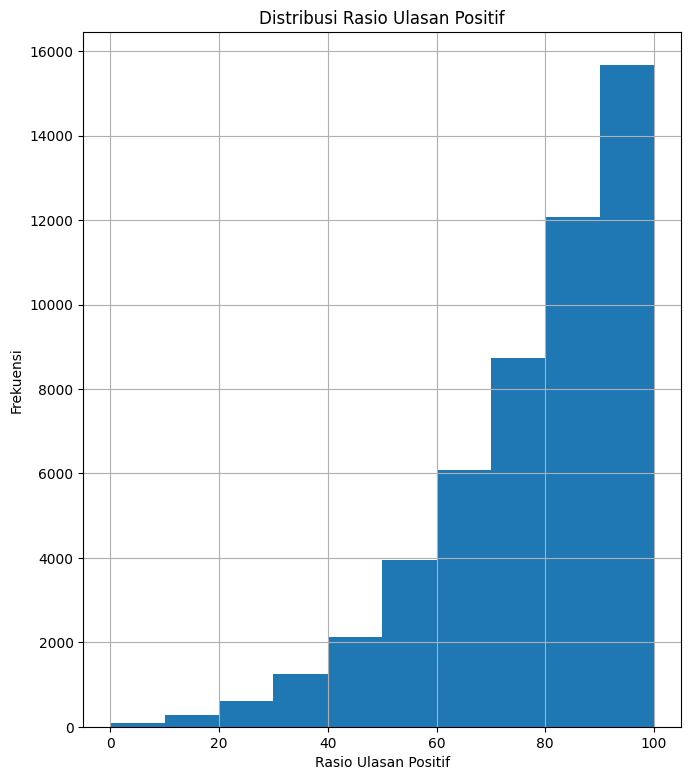

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 3, 3)
final_games['positive_ratio'].hist()
plt.title('Distribusi Rasio Ulasan Positif')
plt.xlabel('Rasio Ulasan Positif')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

Diagram histogram tersebut menggambarkan distribusi rasio ulasan positif dengan sumbu horizontal (x-axis) merepresentasikan persentase rasio ulasan positif dan sumbu vertikal (y-axis) menunjukkan frekuensi.

**Analisis:**
- Rasio ulasan positif memiliki distribusi yang cenderung meningkat seiring bertambahnya nilai rasio.
- Frekuensi tertinggi berada di kisaran rasio **90-100%**, dengan lebih dari 15.000 ulasan yang termasuk dalam kategori ini.
- Kisaran rasio **70-90%** juga memiliki jumlah frekuensi yang signifikan, sekitar 10.000 ulasan.
- Frekuensi menurun drastis pada kisaran rasio di bawah **50%**, menunjukkan bahwa ulasan dengan rasio rendah jarang terjadi.

**Kesimpulan:**
Sebagian besar ulasan memiliki rasio positif yang tinggi, mengindikasikan bahwa produk atau layanan yang dianalisis cenderung mendapatkan respon yang sangat baik dari pengguna.

### 3. Distribusi Rating Game

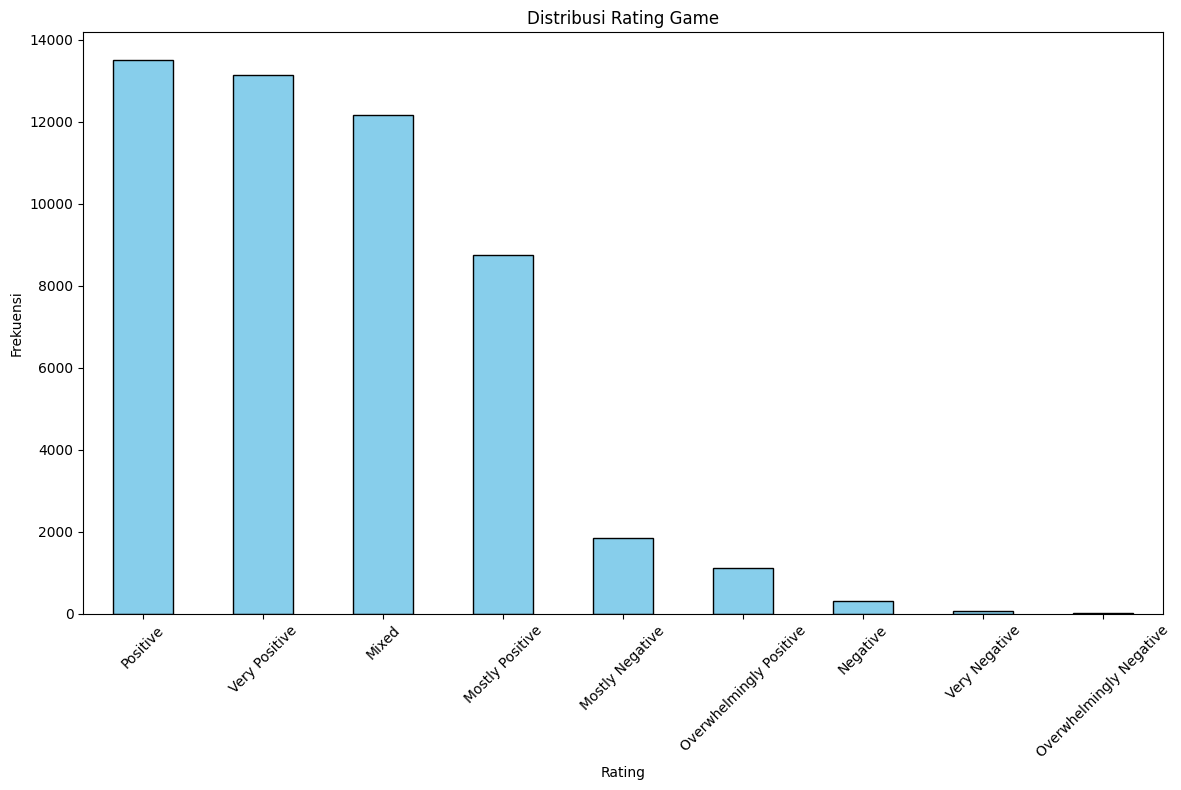

In [ ]:
plt.figure(figsize=(12, 8))
final_games['rating'].value_counts().plot(
    kind='bar',
    color='skyblue',
    edgecolor='black'
)
plt.title('Distribusi Rating Game')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Diagram batang tersebut menunjukkan distribusi berbagai kategori rating game berdasarkan frekuensi. Berikut analisisnya:

1. **Kategori Teratas**:
   - **Positive**, **Very Positive**, dan **Mixed** memiliki jumlah frekuensi tertinggi, masing-masing sekitar 13.000 hingga 14.000 ulasan. Ini menunjukkan bahwa sebagian besar game menerima ulasan yang cenderung positif atau bercampur.

2. **Kategori Menengah**:
   - **Mostly Positive** memiliki jumlah frekuensi yang cukup signifikan, sekitar 8.000 ulasan, yang masih menunjukkan kecenderungan ulasan yang baik.

3. **Kategori Rendah**:
   - **Mostly Negative** memiliki lebih sedikit ulasan dibandingkan kategori lainnya, diikuti oleh **Overwhelmingly Positive**, **Negative**, **Very Negative**, dan **Overwhelmingly Negative**, yang memiliki frekuensi paling rendah.

**Kesimpulan**:
Sebagian besar ulasan game cenderung positif, dengan beberapa ulasan bercampur. Ulasan yang sangat negatif atau sangat positif berada dalam jumlah yang jauh lebih kecil, menunjukkan adanya perbedaan pengalaman yang ekstrem pada sebagian kecil game.

### 4. Distribusi Diskon

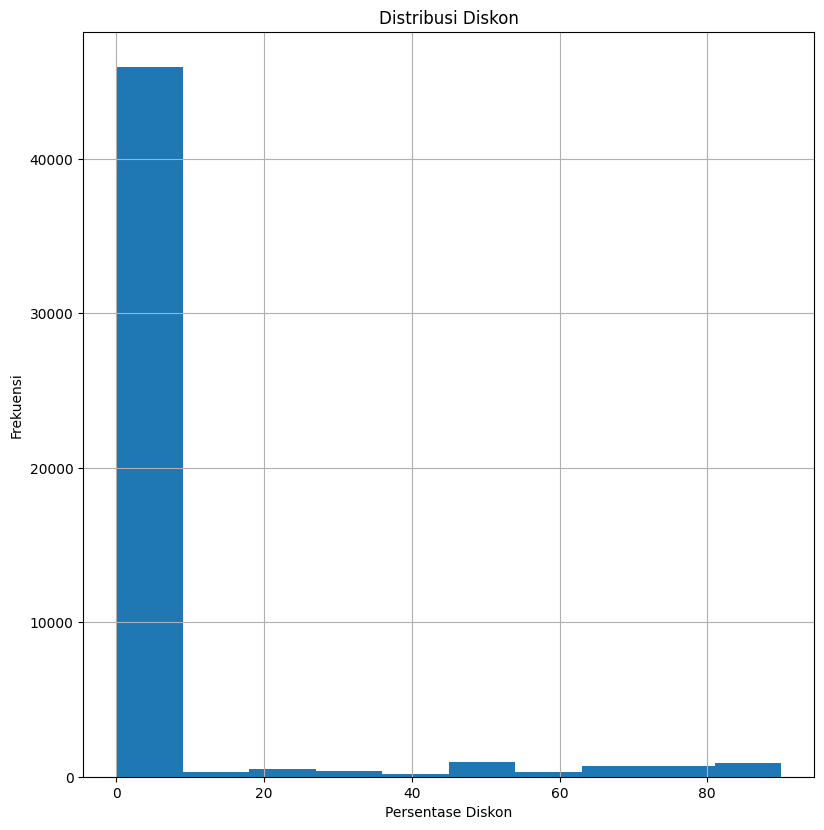

In [ ]:
plt.figure(figsize=(24, 16))
plt.subplot(2, 3, 5)
final_games['discount'].hist()
plt.title('Distribusi Diskon')
plt.xlabel('Persentase Diskon')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

Histogram tersebut menunjukkan distribusi persentase diskon. Mayoritas data terpusat di sekitar nilai 0%, yang mengindikasikan bahwa sebagian besar produk atau transaksi tidak mendapatkan diskon. Frekuensi diskon yang lebih tinggi pada nilai rendah (mendekati 0%) secara signifikan menonjol dibandingkan nilai diskon yang lebih tinggi.

Diskon dengan persentase lebih besar dari 20% hingga mendekati 80% jarang terjadi, terlihat dari jumlah bar yang kecil di kisaran tersebut. Distribusi ini mencerminkan bahwa diskon besar lebih jarang diberikan dibandingkan diskon kecil atau tanpa diskon sama sekali.

Hal ini dapat mengindikasikan strategi pemasaran yang lebih sering menawarkan harga penuh atau diskon minimal, dengan hanya sedikit transaksi yang menawarkan diskon besar sebagai insentif tambahan.

### 5. Distribusi Top 15 Tag Game

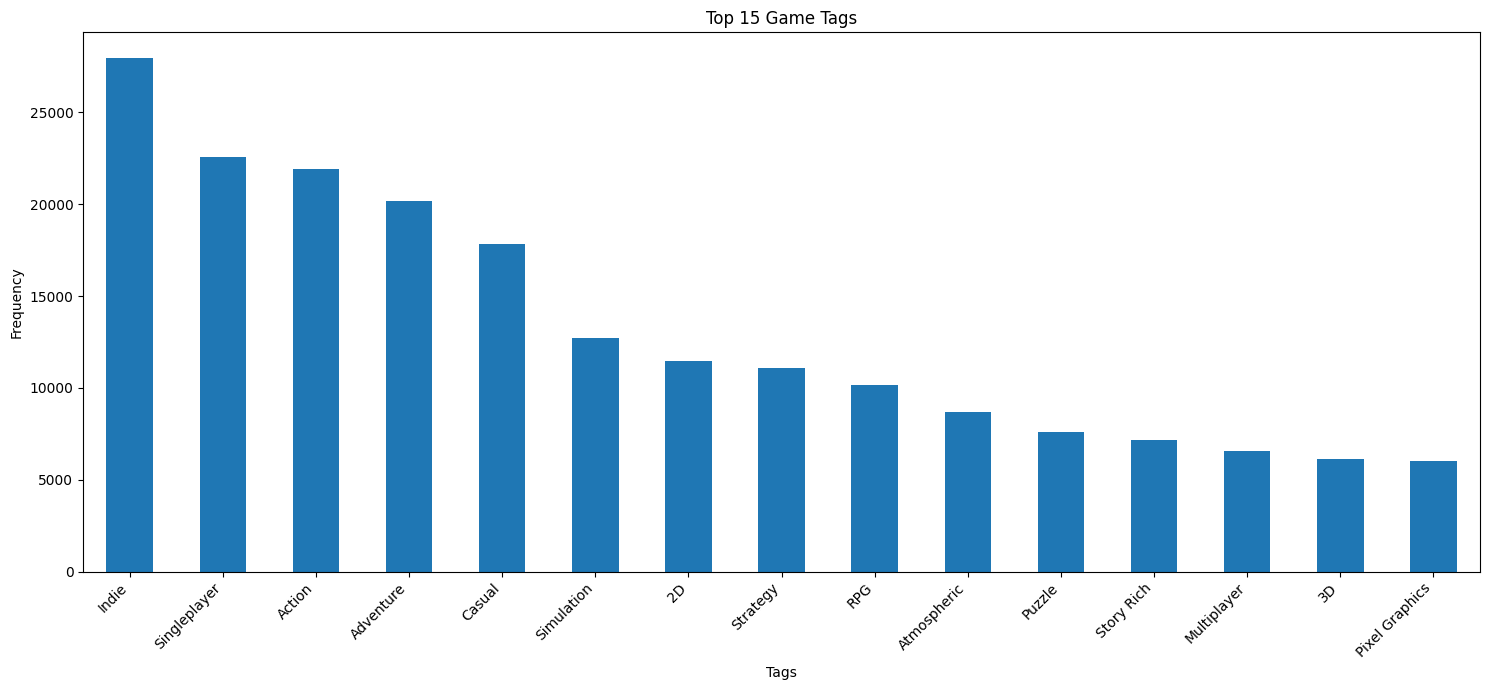

In [ ]:
final_games['parsed_tags'] = final_games['tags'].apply(lambda x: list(x) if isinstance(x, tuple) else [])

# Flatten tags
all_tags = []
for tags_list in final_games['parsed_tags']:
    if isinstance(tags_list, list):
        all_tags.extend(tags_list)

# Hitung frekuensi tag
tag_counts = pd.Series(all_tags).value_counts()

# Visualisasi
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
tag_counts.head(15).plot(kind='bar')
plt.title('Top 15 Game Tags')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Bar chart tersebut menunjukkan 15 tag game terpopuler berdasarkan frekuensinya. Berikut adalah beberapa interpretasi:

1. **Tag Teratas**: Tag "Indie" memiliki frekuensi tertinggi, menunjukkan bahwa game-game indie sangat banyak dan populer dalam dataset ini.
2. **Tag Lain yang Menonjol**: Tag seperti "Singleplayer," "Action," dan "Adventure" juga sangat populer, mengindikasikan bahwa game dengan mode pemain tunggal dan genre aksi atau petualangan sering diminati.
3. **Tag Peringkat Menengah**: Tag seperti "Casual," "Simulation," dan "2D" memiliki frekuensi yang cukup tinggi tetapi lebih rendah dibandingkan kategori teratas.
4. **Tag Paling Rendah dalam Top 15**: "Pixel Graphics" menempati posisi paling bawah dalam daftar ini, namun masih cukup sering digunakan dibandingkan tag lainnya di luar 15 besar.

Secara keseluruhan, data ini menggambarkan preferensi pengguna atau developer yang cenderung membuat atau memainkan game indie, singleplayer, dan bergenre aksi atau petualangan.

### 6. Distribusi Word Cloud Dari Kolom `tags`

In [ ]:
!pip install wordcloud

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess_text(text):
    # Menghapus angka dan simbol selain huruf
    text = ''.join([char if char.isalpha() or char == ' ' else ' ' for char in text])
    return ' '.join([word for word in text.split() if word.lower() not in ENGLISH_STOP_WORDS])

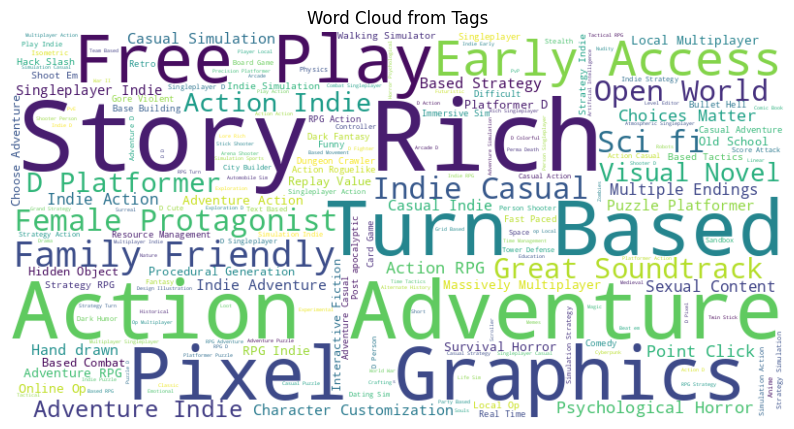

In [ ]:
# Gabungkan parsed_tags menjadi string per game
final_games['tags_str'] = final_games['parsed_tags'].apply(lambda tags: ' '.join(tags))

# Gabungkan semua teks dari tags_str
tags_combined_text = ' '.join(final_games['tags_str'].fillna(''))

# Proses teks untuk menghapus stopwords dan simbol
tags_processed_text = preprocess_text(tags_combined_text)

# Membuat Word Cloud untuk tags
tags_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tags_processed_text)

# Visualisasi WordCloud untuk tags
plt.figure(figsize=(10, 6))
plt.imshow(tags_wordcloud, interpolation='bilinear')
plt.axis('off')  # Menyembunyikan sumbu
plt.title('Word Cloud from Tags')
plt.show()


### Distribusi Word Cloud dari kolom `descriptions`

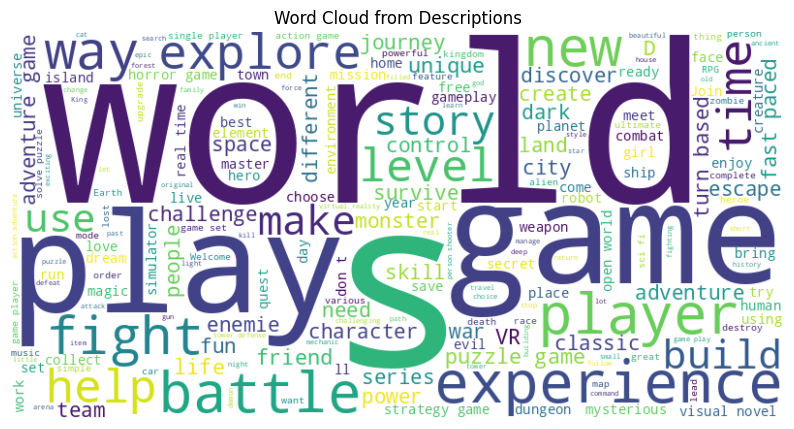

In [ ]:
# Gabungkan semua teks dari description
description_combined_text = ' '.join(final_games['description'].fillna(''))

# Proses teks untuk menghapus stopwords dan simbol
description_processed_text = preprocess_text(description_combined_text)

# Membuat Word Cloud untuk description
description_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(description_processed_text)

# Visualisasi WordCloud untuk description
plt.figure(figsize=(10, 6))
plt.imshow(description_wordcloud, interpolation='bilinear')
plt.axis('off')  # Menyembunyikan sumbu
plt.title('Word Cloud from Descriptions')
plt.show()


## ***Exploratory Data Analysis* (EDA)** - *Multivariate Analysis*

### 1. Distribusi Kolom `is_recommended` dan `hours`

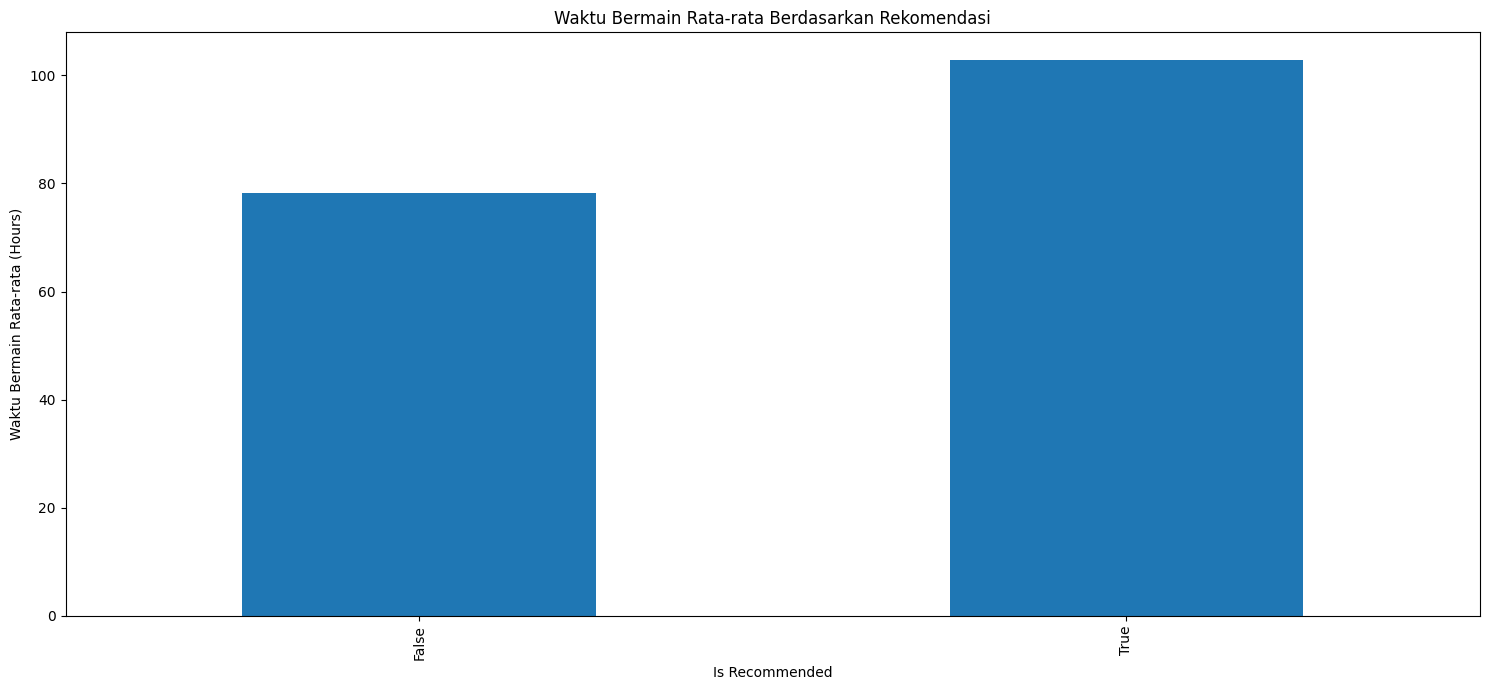

In [ ]:
recommendations_detailed = sample_recommendations.merge(games, on='app_id')
plt.figure(figsize=(15, 7))
recommendations_detailed.groupby('is_recommended')['hours'].mean().plot(kind='bar')
plt.title('Waktu Bermain Rata-rata Berdasarkan Rekomendasi')
plt.xlabel('Is Recommended')
plt.ylabel('Waktu Bermain Rata-rata (Hours)')
plt.tight_layout()
plt.show()

Bar chart tersebut menunjukkan rata-rata waktu bermain (average playtime) dalam jam berdasarkan rekomendasi game (is recommended). Berikut adalah interpretasinya:

1. **Perbedaan Waktu Bermain**:
   - Game yang direkomendasikan (**True**) memiliki rata-rata waktu bermain lebih tinggi dibandingkan game yang tidak direkomendasikan (**False**).
   - Hal ini menunjukkan bahwa pengguna cenderung lebih lama memainkan game yang mereka rekomendasikan.

2. **Implikasi**:
   - Rekomendasi kemungkinan besar berkorelasi dengan tingkat kepuasan atau keterlibatan pengguna terhadap game tersebut.
   - Waktu bermain yang lebih lama dapat menjadi indikator bahwa game tersebut menawarkan pengalaman yang menarik atau gameplay yang memikat.

3. **Kesimpulan**:
   - Untuk meningkatkan rekomendasi, developer atau platform dapat mempertimbangkan pola ini untuk mengidentifikasi game dengan potensi tinggi dalam meningkatkan keterlibatan pemain.

### 2. Analisis Pengguna dengan Produk dan Ulasan

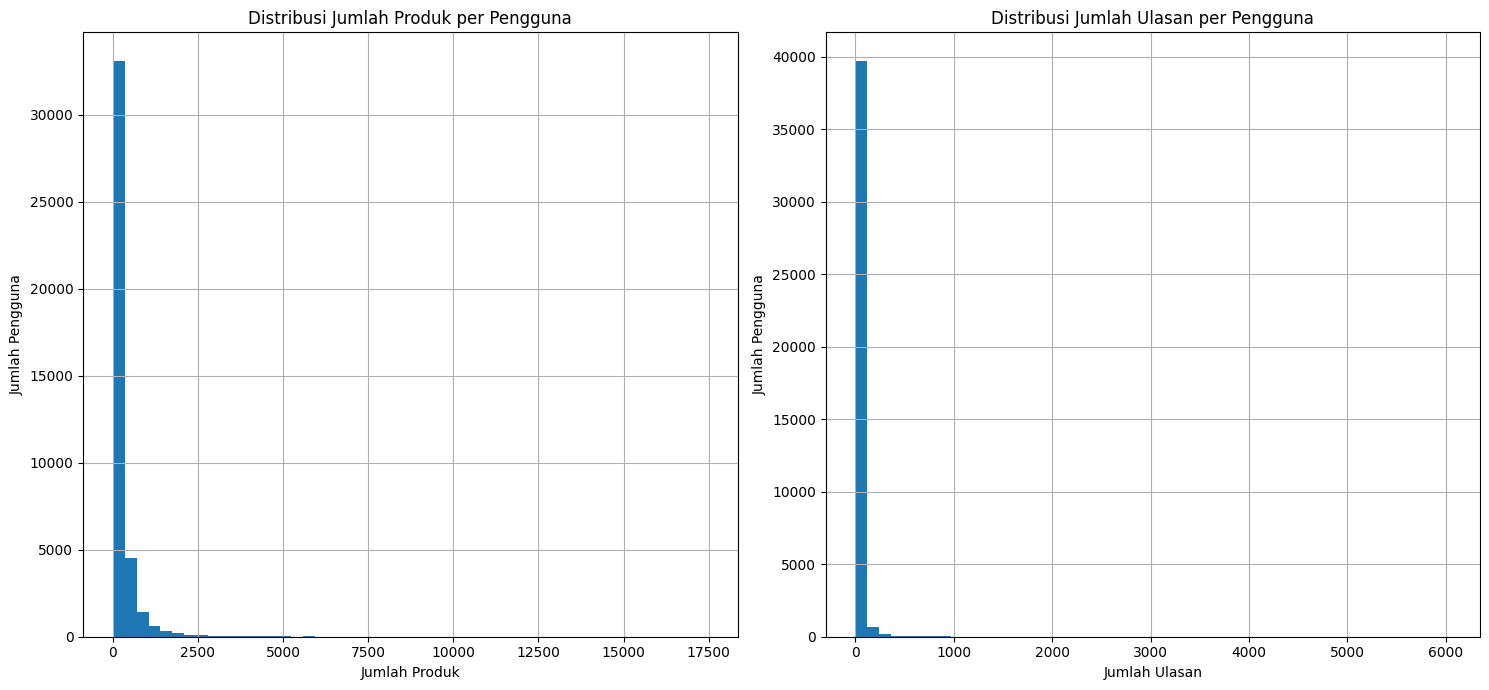

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sample_data_users['products'].hist(bins=50)
plt.title('Distribusi Jumlah Produk per Pengguna')
plt.xlabel('Jumlah Produk')
plt.ylabel('Jumlah Pengguna')

plt.subplot(1, 2, 2)
sample_data_users['reviews'].hist(bins=50)
plt.title('Distribusi Jumlah Ulasan per Pengguna')
plt.xlabel('Jumlah Ulasan')
plt.ylabel('Jumlah Pengguna')
plt.tight_layout()
plt.show()

Gambar tersebut menampilkan dua histogram untuk mendistribusikan data pengguna berdasarkan jumlah produk dan ulasan. Berikut interpretasinya:

1. **Distribusi Jumlah Produk per Pengguna (kiri)**:
   Histogram ini menunjukkan bahwa sebagian besar pengguna hanya berinteraksi dengan sejumlah kecil produk. Mayoritas pengguna berada di kisaran jumlah produk yang sangat rendah, dan jumlah pengguna berkurang drastis seiring bertambahnya jumlah produk yang mereka interaksikan. Ada ekor panjang (long tail) yang menunjukkan bahwa sedikit pengguna memiliki jumlah produk yang sangat tinggi.

2. **Distribusi Jumlah Ulasan per Pengguna (kanan)**:
   Pola serupa terlihat pada distribusi ulasan. Sebagian besar pengguna memberikan sangat sedikit ulasan, dengan jumlah pengguna yang menurun tajam seiring bertambahnya jumlah ulasan yang dibuat. Sama seperti grafik pertama, terdapat ekor panjang yang menunjukkan bahwa hanya sejumlah kecil pengguna yang memberikan ulasan dalam jumlah besar.

Secara keseluruhan, kedua distribusi ini menunjukkan pola yang sangat mirip, dengan sebagian besar aktivitas terkonsentrasi pada sebagian kecil pengguna, dan hanya sedikit pengguna yang sangat aktif dalam hal jumlah produk yang diulas atau jumlah ulasan yang dibuat. Fenomena ini umum dalam data interaksi pengguna, yang sering kali mengikuti distribusi yang tidak merata.

### 3. Korelasi antara kolom `price_final`, `positive_ratio`, `user_reviews` dan `discount`

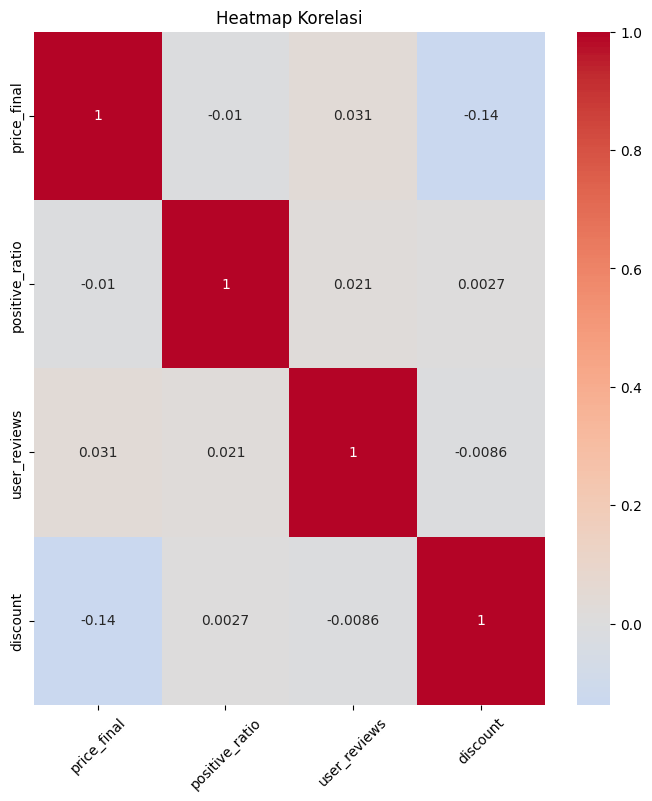

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 3, 1)
numeric_columns = ['price_final', 'positive_ratio', 'user_reviews', 'discount']
correlation_matrix = final_games[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap Korelasi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Gambar tersebut adalah **heatmap korelasi** yang menggambarkan hubungan antara beberapa variabel: `price_final`, `positive_ratio`, `user_reviews`, dan `discount`. Berikut interpretasinya:

1. **Hubungan antar variabel**:
   - Korelasi antara `price_final` dan `discount` adalah negatif (-0.14), menunjukkan bahwa harga akhir cenderung menurun jika diskon meningkat, meskipun korelasinya lemah.
   - Korelasi antara variabel lain (misalnya `positive_ratio` dengan `price_final`, `user_reviews`, dan `discount`) mendekati nol, menunjukkan tidak adanya hubungan linear yang signifikan di antara mereka.

2. **Kesimpulan utama**:
   - Sebagian besar variabel tidak memiliki hubungan yang kuat, dengan korelasi mendekati nol.
   - Hanya ada hubungan lemah yang signifikan antara `price_final` dan `discount`.

Heatmap ini berguna untuk mengevaluasi hubungan awal antar variabel sebelum melakukan analisis lebih lanjut. Korelasi lemah ini mungkin menunjukkan bahwa faktor-faktor ini perlu dieksplorasi lebih jauh dengan metode selain regresi linier sederhana.

### 4. Distribusi Harga dan Rasio Review Positif

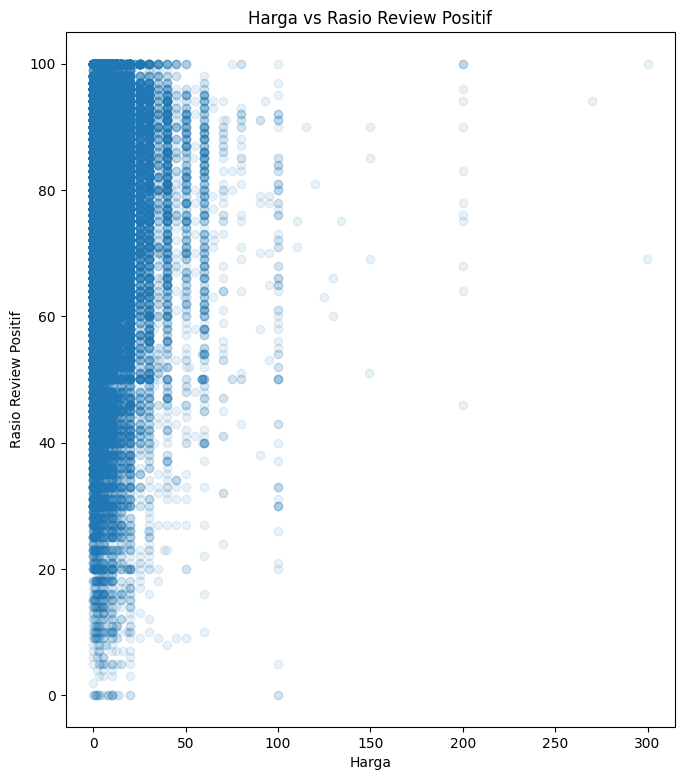

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 3, 2)
plt.scatter(final_games['price_final'], final_games['positive_ratio'], alpha=0.1)
plt.title('Harga vs Rasio Review Positif')
plt.xlabel('Harga')
plt.ylabel('Rasio Review Positif')
plt.tight_layout()
plt.show()

Gambar tersebut adalah scatter plot yang menunjukkan hubungan antara **Harga (x-axis)** dan **Rasio Review Positif (y-axis)**. Berikut adalah interpretasinya:

1. **Distribusi Data**:
   - Sebagian besar produk memiliki harga rendah (di bawah 50) dengan berbagai rasio review positif.
   - Rasio review positif berkisar dari 0 hingga 100, tetapi tidak ada pola hubungan yang jelas antara harga dan rasio review positif.

2. **Pengamatan**:
   - Pada harga tinggi (lebih dari 100), jumlah produk sangat sedikit, tetapi rasio review positif tetap beragam.
   - Produk dengan rasio review positif tinggi tidak terbatas pada kategori harga tertentu.

Scatter plot ini membantu dalam visualisasi data untuk mengidentifikasi pola hubungan atau outlier yang membutuhkan perhatian lebih lanjut.

### 5. Distribusi Harga game berdasarkan seluruh platform

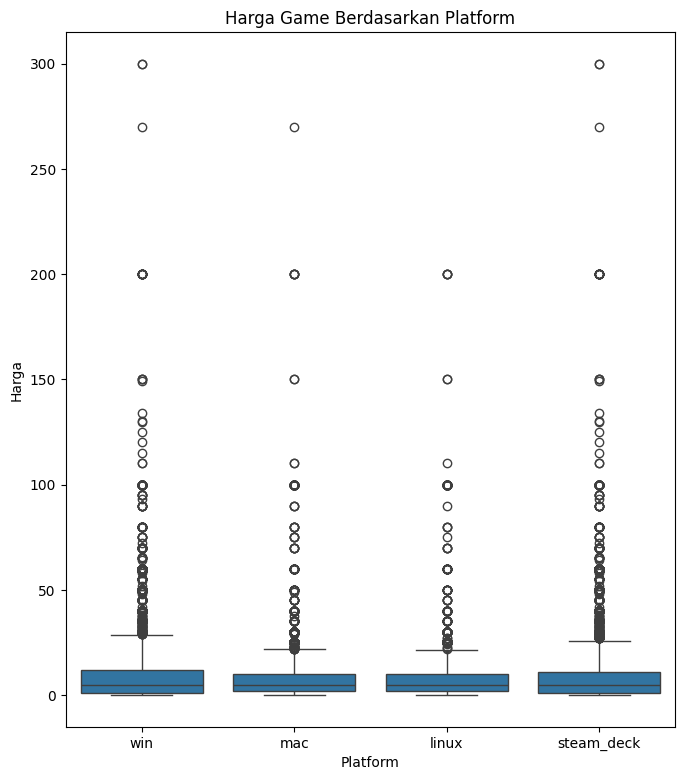

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 3, 3)
platform_data = pd.melt(
    final_games,
    id_vars=['price_final'],
    value_vars=['win', 'mac', 'linux', 'steam_deck'],
    var_name='Platform',
    value_name='Supported'
)

# Filter data untuk platform yang didukung
filtered_data = platform_data[platform_data['Supported']]

# Menggunakan Seaborn untuk boxplot
sns.boxplot(data=filtered_data, x='Platform', y='price_final')
plt.title('Harga Game Berdasarkan Platform')
plt.ylabel('Harga')
plt.xlabel('Platform')
plt.tight_layout()
plt.show()

Gambar tersebut merupakan diagram kotak (boxplot) yang menunjukkan distribusi harga game berdasarkan platform, yaitu Windows (win), Mac, Linux, dan Steam Deck. Setiap kotak dalam diagram mewakili rentang interkuartil (IQR) dari harga game, dengan garis di dalam kotak yang menunjukkan median harga. "Whiskers" atau garis di luar kotak menggambarkan rentang data yang masih dianggap sebagai bagian dari distribusi normal, sementara titik-titik di luar whiskers merupakan outlier atau harga yang jauh lebih tinggi dari biasanya.

Berdasarkan diagram ini, dapat dilihat bahwa:

1. Sebagian besar harga game untuk semua platform berada dalam rentang yang mirip, dengan median harga yang relatif sama.
2. Ada beberapa outlier dengan harga yang jauh lebih tinggi dari kebanyakan game, terutama pada kisaran harga 100 hingga 300.
3. Distribusi harga game untuk setiap platform tampaknya cukup simetris, tanpa perbedaan yang signifikan antara platform yang satu dengan yang lain.
4. Dari segi variabilitas, semua platform memiliki rentang harga yang hampir serupa, menunjukkan bahwa tidak ada platform yang secara signifikan lebih mahal atau lebih murah dibandingkan yang lain.

Secara keseluruhan, diagram ini menunjukkan bahwa harga game cukup konsisten di semua platform, meskipun ada beberapa game yang memiliki harga jauh lebih tinggi yang dianggap sebagai outlier.

### 6. Distribusi Diskon dan Harga

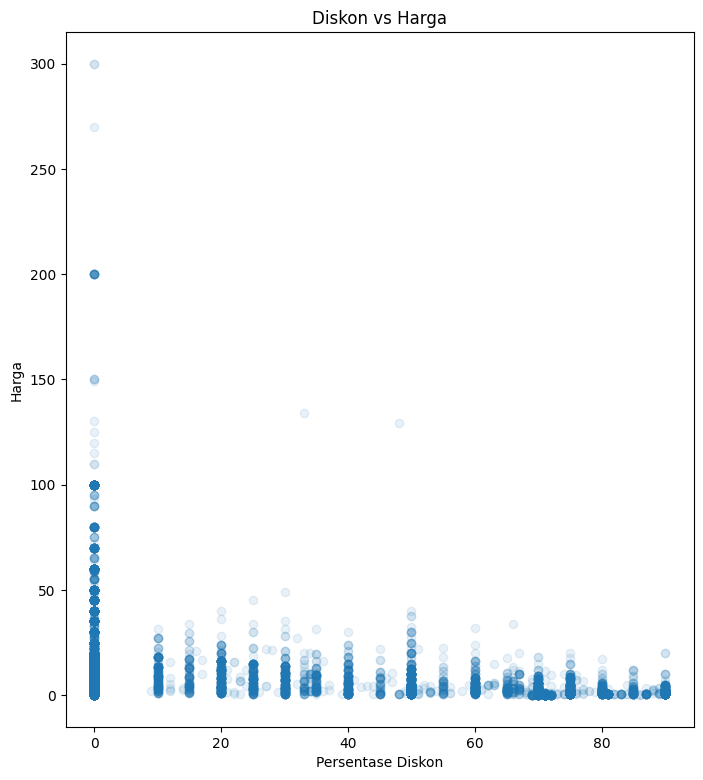

In [ ]:
 #4. Diskon vs Harga
plt.figure(figsize=(20, 15))
plt.subplot(2, 3, 4)
plt.scatter(final_games['discount'], final_games['price_final'], alpha=0.1)
plt.title('Diskon vs Harga')
plt.xlabel('Persentase Diskon')
plt.ylabel('Harga')
plt.tight_layout()
plt.show()

Gambar ini adalah diagram sebar (scatter plot) yang menunjukkan hubungan antara persentase diskon dan harga game. Sumbu horizontal (x) merepresentasikan persentase diskon, sementara sumbu vertikal (y) merepresentasikan harga game.

Dari diagram ini, beberapa hal yang dapat diinterpretasikan adalah:

1. **Sebaran Diskon**:
   - Sebagian besar game memiliki diskon antara 0% hingga 60%.
   - Hanya sedikit game yang memiliki diskon lebih dari 60%.

2. **Harga Game dengan Diskon Rendah**:
   - Banyak game yang memiliki harga tinggi meskipun diskonnya kecil (0% hingga 20%). Game-game ini cenderung berada di bagian atas kiri diagram.

3. **Harga Game dengan Diskon Tinggi**:
   - Game dengan diskon yang lebih tinggi (lebih dari 60%) cenderung memiliki harga yang lebih rendah, terlihat dari sebaran titik-titik yang lebih rendah pada sumbu y.

4. **Outliers**:
   - Ada beberapa game dengan harga sangat tinggi (mencapai 300) yang meskipun diberikan diskon, tetap memiliki harga yang cukup tinggi.

5. **Konsentrasi Harga**:
   - Harga game paling banyak berkisar antara 0 hingga 50, dengan berbagai tingkat diskon yang diberikan.
   
Secara keseluruhan, diagram ini menunjukkan bahwa meskipun ada berbagai tingkat diskon yang diterapkan, game-game dengan harga lebih tinggi cenderung memiliki diskon yang lebih kecil. Sementara game dengan harga lebih rendah lebih mungkin mendapatkan diskon yang lebih besar. Hal ini bisa menunjukkan strategi penetapan harga di mana game yang lebih murah diberikan diskon lebih besar untuk menarik lebih banyak pembeli.

### 7. Distribusi Jumlah Review dan Rasio Positif

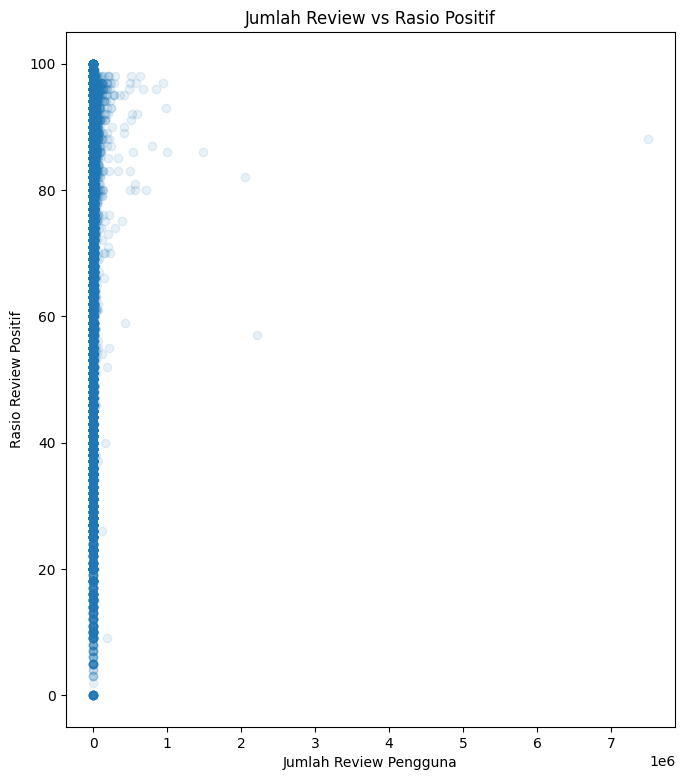

In [ ]:
# 5. Jumlah Review vs Rasio Positif
plt.figure(figsize=(20, 15))
plt.subplot(2, 3, 5)
plt.scatter(final_games['user_reviews'], final_games['positive_ratio'], alpha=0.1)
plt.title('Jumlah Review vs Rasio Positif')
plt.xlabel('Jumlah Review Pengguna')
plt.ylabel('Rasio Review Positif')
plt.tight_layout()
plt.show()

Gambar ini adalah diagram sebar (scatter plot) yang menunjukkan hubungan antara jumlah review pengguna dan rasio review positif. Sumbu horizontal (x) merepresentasikan jumlah review pengguna, sedangkan sumbu vertikal (y) merepresentasikan rasio review positif.

Berikut adalah beberapa interpretasi dari diagram ini:

1. **Sebaran Review Positif**:
   - Sebagian besar game memiliki rasio review positif yang tinggi, terutama di atas 80%. Titik-titik ini terkonsentrasi di bagian atas diagram.
   - Hanya sedikit game yang memiliki rasio review positif di bawah 40%.

2. **Jumlah Review Pengguna**:
   - Kebanyakan game memiliki jumlah review yang rendah, terlihat dari banyaknya titik yang berada di dekat sumbu y (jumlah review pengguna mendekati 0).
   - Ada beberapa outlier dengan jumlah review yang sangat tinggi, mencapai lebih dari 1 juta review.

3. **Hubungan antara Review dan Positif**:
   - Tidak ada hubungan yang jelas antara jumlah review pengguna dan rasio review positif. Baik game dengan jumlah review yang sedikit maupun banyak dapat memiliki rasio review positif yang tinggi.

4. **Outliers**:
   - Ada beberapa game yang memiliki jumlah review sangat tinggi (lebih dari 1 juta), namun tetap memiliki rasio review positif yang beragam.
   - Game dengan jumlah review lebih dari 3 juta umumnya memiliki rasio review positif di atas 60%.

Secara keseluruhan, diagram ini menunjukkan bahwa banyak game memiliki rasio review positif yang tinggi terlepas dari jumlah review yang mereka terima. Game yang menerima banyak review cenderung juga memiliki review positif yang tinggi, tetapi ada variabilitas yang signifikan dalam data.

# Sistem Rekomendasi Games - Content-based Filtering

## Persiapan Data

Memilih kolom yang diperlukan dari dataset final_game

In [ ]:
df = final_games[['app_id', 'title','description', 'tags']]

In [ ]:
df.head()

,app_id,title,description,tags
0,13500,Prince of Persia: Warrior Within™,Enter the dark underworld of Prince of Persia ...,"(Action, Adventure, Parkour, Third Person, Gre..."
1,22364,BRINK: Agents of Change,,"(Action,)"
2,113020,Monaco: What's Yours Is Mine,Monaco: What's Yours Is Mine is a single playe...,"(Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island,Escape Dead Island is a Survival-Mystery adven...,"(Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the ENDLESS™,Dungeon of the Endless is a Rogue-Like Dungeon...,"(Roguelike, Strategy, Tower Defense, Pixel Gra..."


Menggabungkan tags menjadi string tunggal

In [ ]:
df.loc[:, 'tags'] = df['tags'].apply(lambda x:' '.join(x))

Membuat salinan dataframe dan Membuat kolom overview dengan menggabungkan title, description, dan tags

In [ ]:
df = df.copy()
df.loc[:, 'overview'] = df['title'] + " " + df['description'] + " " + df['tags']
df.head()

,app_id,title,description,tags,overview
0,13500,Prince of Persia: Warrior Within™,Enter the dark underworld of Prince of Persia ...,Action Adventure Parkour Third Person Great So...,Prince of Persia: Warrior Within™ Enter the da...
1,22364,BRINK: Agents of Change,,Action,BRINK: Agents of Change Action
2,113020,Monaco: What's Yours Is Mine,Monaco: What's Yours Is Mine is a single playe...,Co-op Stealth Indie Heist Local Co-Op Strategy...,Monaco: What's Yours Is Mine Monaco: What's Yo...
3,226560,Escape Dead Island,Escape Dead Island is a Survival-Mystery adven...,Zombies Adventure Survival Action Third Person...,Escape Dead Island Escape Dead Island is a Sur...
4,249050,Dungeon of the ENDLESS™,Dungeon of the Endless is a Rogue-Like Dungeon...,Roguelike Strategy Tower Defense Pixel Graphic...,Dungeon of the ENDLESS™ Dungeon of the Endless...


Membuat dataframe final dengan kolom app_id, title, dan overview

In [ ]:
final_df = df[['app_id','title','overview']]
final_df.head()

,app_id,title,overview
0,13500,Prince of Persia: Warrior Within™,Prince of Persia: Warrior Within™ Enter the da...
1,22364,BRINK: Agents of Change,BRINK: Agents of Change Action
2,113020,Monaco: What's Yours Is Mine,Monaco: What's Yours Is Mine Monaco: What's Yo...
3,226560,Escape Dead Island,Escape Dead Island Escape Dead Island is a Sur...
4,249050,Dungeon of the ENDLESS™,Dungeon of the ENDLESS™ Dungeon of the Endless...


## Pembersihan Teks

Fungsi untuk menghapus karakter khusus

In [ ]:
def remove_special_characters(s):
  return re.sub(r'[^\w\s]', '', s)

Menerapkan pembersihan pada kolom overview

In [ ]:
df['overview'] = df['overview'].apply(lambda x : remove_special_characters(x))

## Stemming Teks

Membuat Fungsi untuk melakukan stemming pada teks

In [ ]:
ps = PorterStemmer()
def stem(text):
    y = []
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)

Selanjutnya mari kita terapkan stemming pada kolom overview

In [ ]:
df['overview'] = df['overview'].apply(stem)

## Vektorisasi Teks

Membuat CountVectorizer dengan batasan fitur

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=1500,stop_words='english')

In [ ]:
cv.fit_transform(df['overview']).toarray().shape

(50872, 1500)

Mengubah teks menjadi vektor numerik

In [ ]:
vectors = cv.fit_transform(df['overview']).toarray()

In [ ]:
similarity = cosine_similarity(vectors)

Penjelasan:

- Mengonversi teks menjadi vektor numerik
- Membatasi jumlah fitur maksimal 1500
- Menghapus kata-kata umum (stop words) dalam bahasa Inggris
- Menghitung similaritas antar game menggunakan metode kosinus
- Menghasilkan matriks similaritas untuk semua game

In [ ]:
similarity

array([[1.        , 0.06579517, 0.09056668, ..., 0.        , 0.11396058,
        0.        ],
       [0.06579517, 1.        , 0.07647191, ..., 0.        , 0.08247861,
        0.        ],
       [0.09056668, 0.07647191, 1.        , ..., 0.        , 0.05676567,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.11396058, 0.08247861, 0.05676567, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Fungsi Rekomendasi

In [ ]:
def recommend(game):
    # Periksa apakah game ada dalam DataFrame
    if game not in final_df['title'].values:
        print("Game not found in the dataset.")
        return

    # Jika game ada, lanjutkan dengan rekomendasi
    game_index = final_df[final_df['title'] == game].index[0]
    distances = similarity[game_index]
    game_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:11]

    for i in game_list:
        print(final_df.iloc[i[0]].title)


## Pengujian penggunaan fungsi rekomendasi

In [ ]:
recommend('Prince of Persia: Warrior Within™')

Prince of Persia®: The Sands of Time
Prince of Persia: The Two Thrones™
Prince of Persia®
Prince of Persia: The Forgotten Sands™
Legacy of Kain: Soul Reaver 2
DARK SOULS™ III - The Ringed City™
BERSERK and the Band of the Hawk
Dark Fantasy Warriors
Dark Cave
Dragon's Dogma: Dark Arisen


Sistem rekomendasi berbasis konten yang telah dikembangkan menunjukkan hasil yang menarik ketika diaplikasikan pada game Prince of Persia: Warrior Within™. Algoritma berhasil mengidentifikasi serangkaian game yang memiliki kesamaan signifikan, dengan fokus utama pada seri Prince of Persia dan game bergenre action-adventure dark fantasy.
Dari sepuluh game yang direkomendasikan, empat di antaranya berasal dari seri Prince of Persia itu sendiri, yang menandakan keberhasilan algoritma dalam mengenali game-game dengan tema dan karakteristik serupa. Metode content-based filtering yang digunakan memanfaatkan teknik vektorisasi teks, stemming, dan cosine similarity untuk mengekstrak dan membandingkan fitur-fitur semantik dari game yang ada dalam dataset.

Keunikan pendekatan ini terletak pada kemampuannya menangkap nuansa teks yang ada dalam deskripsi, judul, dan tag game. Algoritma berhasil menemukan game-game dengan tema petualangan, pertarungan, dan dunia fantasi gelap, yang secara konseptual mirip dengan Prince of Persia: Warrior Within™. Rekomendasi seperti Legacy of Kain: Soul Reaver 2, DARK SOULS™ III - The Ringed City™, dan Dragon's Dogma: Dark Arisen menunjukkan kedalaman analisis semantik yang dilakukan sistem.

Meskipun demikian, metode ini memiliki beberapa keterbatasan. Karena hanya mengandalkan konten teks, sistem tidak mempertimbangkan faktor-faktor seperti rating pengguna, gameplay aktual, atau preferensi personal. Ke depannya, pengembangan algoritma dapat difokuskan pada pengintegrasian sumber data tambahan, penggunaan teknik vektorisasi yang lebih canggih seperti word embedding, dan penambahan fitur genre yang lebih eksplisit.

Kesuksesan relatif dari sistem rekomendasi ini membuka peluang untuk eksplorasi lebih lanjut dalam bidang recommender systems, khususnya untuk katalog game yang memiliki kekayaan deskriptif dan tema yang kompleks. Pendekatan content-based filtering membuktikan dirinya sebagai metode yang powerful dalam mengeksplorasi keterkaitan antar game berdasarkan karakteristik intrinsik mereka.

# Sistem Rekomendasi Games - Collaborative Filtering

Sistem rekomendasi ini menggunakan metode Collaborative Filtering untuk memberikan rekomendasi game berdasarkan preferensi pengguna. Pendekatan ini memanfaatkan kesamaan antara pengguna atau game untuk menghasilkan rekomendasi personal.

### Persiapan Matriks User-Item

Membuat matriks yang menggambarkan hubungan antara pengguna dan game yang direkomendasikan.

In [ ]:
# Buat matriks user-item
user_item_matrix = sample_recommendations.pivot_table(
    index='user_id',
    columns='app_id',
    values='is_recommended',
    aggfunc='first'
).fillna(0)

Penjelasan:

- pivot_table() digunakan untuk mengubah dataset menjadi matriks
- index='user_id': Baris mewakili pengguna
- columns='app_id': Kolom mewakili game
- values='is_recommended': Nilai menunjukkan apakah game direkomendasikan
- fillna(0): Mengisi nilai kosong dengan 0

### Menghitung Kesamaan Antar Pengguna

Tujuan nya untuk mengukur tingkat kesamaan antara pengguna berdasarkan preferensi game.

In [ ]:
# Hitung cosine similarity antar user
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(
    user_similarity,
    index=user_item_matrix.index,
    columns=user_item_matrix.index
)

Penjelasan:

- `cosine_similarity()` menghitung kesamaan antara vektor pengguna
- Semakin tinggi nilai, semakin mirip preferensi game pengguna

### Pengujian Sistem Rekomendasi untuk Pengguna Tertentu

Memberikan rekomendasi game untuk seorang pengguna berdasarkan kesamaan dengan pengguna lain.

In [ ]:
# Pilih user_id contoh
example_user_id = 10317527

if example_user_id in user_item_matrix.index:
    # Temukan index user
    user_index = user_item_matrix.index.get_loc(example_user_id)

    # Cari users terdekat
    similar_users = user_similarity[user_index]
    similar_users_indices = similar_users.argsort()[::-1][1:6]

    # Game yang direkomendasikan
    recommended_games = []
    for similar_user_index in similar_users_indices:
        similar_user_id = user_item_matrix.index[similar_user_index]
        similar_user_games = user_item_matrix.loc[similar_user_id]
        recommended_games.extend(
            similar_user_games[similar_user_games == 1].index.tolist()
        )

    # Filter dan ranking
    recommended_games = list(set(recommended_games))
    user_recommendations = final_games[final_games['app_id'].isin(recommended_games)].sort_values('positive_ratio', ascending=False).head(5)
    print(f"Recommended games for user {example_user_id}:")
    print(user_recommendations[['title', 'positive_ratio']])
else:
    print(f"User {example_user_id} not found in the dataset.")

Recommended games for user 10317527:
                                                   title  positive_ratio
47394                    Plants vs. Zombies GOTY Edition              97
47428  The Elder Scrolls III: Morrowind® Game of the ...              95
2620                              Turok 2: Seeds of Evil              93
14457                                           Warframe              86


Penjelasan Alur:

- Pilih pengguna contoh
- Temukan 5 pengguna dengan preferensi terdekat
- Kumpulkan game yang direkomendasikan pengguna serupa
- Saring dan ranking game berdasarkan rasio positif

### Rekomendasi Game Serupa

Menemukan game yang mirip dengan game tertentu berdasarkan preferensi pengguna.

In [ ]:
# Buat matriks item-item
item_item_matrix = sample_recommendations.pivot_table(
    index='app_id',
    columns='user_id',
    values='is_recommended',
    aggfunc='first'
).fillna(0)

### Hitung similarity antar item

In [ ]:
# Hitung similarity antar item
item_similarity = cosine_similarity(item_item_matrix)
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=item_item_matrix.index,
    columns=item_item_matrix.index
)


### Melakukan Pengujian Collaborative Filtering

In [ ]:
# Pilih game contoh
example_game_id = final_games['app_id'].iloc[0]

# Temukan index game
game_index = item_item_matrix.index.get_loc(example_game_id)

# Cari game terdekat
similar_games_indices = item_similarity[game_index].argsort()[::-1][1:6]
similar_game_ids = item_item_matrix.index[similar_games_indices]

# Filter dan ranking
similar_games = final_games[final_games['app_id'].isin(similar_game_ids)].sort_values('positive_ratio', ascending=False)

In [ ]:
print("Rekomendasi Game untuk User", example_user_id)
print(user_recommendations[['app_id', 'title', 'positive_ratio']])

print("\nGame Serupa dengan", final_games[final_games['app_id'] == example_game_id]['title'].values[0])
print(similar_games[['app_id', 'title', 'positive_ratio']])

Rekomendasi Game untuk User 10317527
       app_id                                              title  \
47394    3590                    Plants vs. Zombies GOTY Edition   
47428   22320  The Elder Scrolls III: Morrowind® Game of the ...   
2620   405830                             Turok 2: Seeds of Evil   
14457  230410                                           Warframe   

       positive_ratio  
47394              97  
47428              95  
2620               93  
14457              86  

Game Serupa dengan Prince of Persia: Warrior Within™
       app_id                         title  positive_ratio
12101  398850  Epistory - Typing Chronicles              94
3778   399640                    Flamebreak              93
14491  399810              Call of Cthulhu®              78
19362  399120                      Prospekt              62
22268  399420                     The Prism              62


Penjelasan Alur:

- Buat matriks item-item menggunakan pivot table
- Hitung kesamaan antar game menggunakan cosine similarity
- Pilih contoh game
- Temukan 5 game terdekat
- Saring dan ranking game berdasarkan rasio positif

### **Kesimpulan**
Metode Collaborative Filtering memungkinkan kita memberikan rekomendasi game yang personal dan relevan berdasarkan preferensi pengguna dan kesamaan antara pengguna atau game.

# Sistem Rekomendasi Games - Hybrid Recommendation System

### Data Preprocessing

Konversi tipe data tags dari tuple menjadi list menggunakan `final_games['tags_list'] = final_games['tags'].apply(list)`.

In [ ]:
# Cleaning tags
final_games['tags_list'] = final_games['tags'].apply(list)  # Konversi tuple ke list

Menggunakan `MultiLabelBinarizer` untuk mengubah tags menjadi format one-hot encoding.

In [ ]:
# Multi-label binarization untuk tags
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(final_games['tags_list'])
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

Menggunakan `Tokenizer` untuk melakukan tokenisasi pada deskripsi game, dan `pad_sequences` untuk menyeragamkan panjang sekuen.

In [ ]:
# Tokenisasi description
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(final_games['description'])
description_sequences = tokenizer.texts_to_sequences(final_games['description'])

# Padding sequences
max_length = 100
description_padded = pad_sequences(description_sequences, maxlen=max_length, padding='post', truncating='post')

### Feature Engineering

Menggabungkan fitur tags dan deskripsi game menjadi satu input dan Menggunakan Normalization layer untuk menormalisasi fitur harga.

In [ ]:
# Combine tags dan description features
X_tags = tags_df.values
X_description = description_padded

# Reshape the array to ensure it's a 2D array
price_values = final_games['price_final'].values.reshape(-1, 1)

# Create the normalization layer
price_scaler = tf.keras.layers.Normalization(axis=None)
price_scaler.adapt(price_values)

platform_features = final_games[['win', 'mac', 'linux', 'steam_deck']].values

Normalisasi positive ratio

In [ ]:
y = final_games['positive_ratio'].values / 100

### Model Architecture

Memisahkan Data train dan test

In [ ]:
X_train_tags, X_test_tags, X_train_desc, X_test_desc, X_train_platform, X_test_platform, y_train, y_test = train_test_split(
    X_tags, X_description, platform_features, y,
    test_size=0.2, random_state=42
)

Menggunakan tiga input layer untuk menerima fitur tags, deskripsi, dan platform.

In [ ]:
# Input layers
input_tags = Input(shape=(X_train_tags.shape[1],), name='tags_input')
input_description = Input(shape=(max_length,), name='description_input')
input_platform = Input(shape=(4,), name='platform_input')

 Menggunakan Embedding layer untuk mempelajari representasi vektor dari deskripsi game.

In [ ]:

# Embedding layer untuk description
embedding_layer = Embedding(input_dim=5000, output_dim=50, input_length=max_length)
description_embedded = embedding_layer(input_description)
description_flattened = Flatten()(description_embedded)

Menggabungkan fitur tags, deskripsi, dan platform menggunakan `Concatenate`.

In [ ]:

# Concatenate features
merged_features = Concatenate()([
    input_tags,
    description_flattened,
    input_platform
])

Menggunakan dua hidden layer fully connected dengan aktivasi ReLU dan Menggunakan satu output layer dengan aktivasi sigmoid untuk memprediksi positive_ratio.

In [ ]:

# Hidden layers
hidden_layer1 = Dense(128, activation='relu')(merged_features)
hidden_layer2 = Dense(64, activation='relu')(hidden_layer1)
output_layer = Dense(1, activation='sigmoid')(hidden_layer2)

### Model Training

Mengompilasi model dengan optimizer Adam dan loss mean squared error.

In [ ]:
# Compile model
recommender_model = Model(
    inputs=[input_tags, input_description, input_platform],
    outputs=output_layer
)

recommender_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

Melatih model selama 50 epoch dengan batch size 32.

In [ ]:
history = recommender_model.fit(
    [X_train_tags, X_train_desc, X_train_platform],
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32
)

Epoch 1/50
1018/1018 [==============================] - 24s 23ms/step - loss: 0.0288 - mae: 0.1317 - val_loss: 0.0293 - val_mae: 0.1376
Epoch 2/50
1018/1018 [==============================] - 22s 21ms/step - loss: 0.0211 - mae: 0.1101 - val_loss: 0.0321 - val_mae: 0.1378
Epoch 3/50
1018/1018 [==============================] - 22s 22ms/step - loss: 0.0127 - mae: 0.0814 - val_loss: 0.0319 - val_mae: 0.1348
Epoch 4/50
1018/1018 [==============================] - 21s 21ms/step - loss: 0.0097 - mae: 0.0669 - val_loss: 0.0328 - val_mae: 0.1374
Epoch 5/50
1018/1018 [==============================] - 21s 21ms/step - loss: 0.0086 - mae: 0.0605 - val_loss: 0.0336 - val_mae: 0.1399
Epoch 6/50
1018/1018 [==============================] - 21s 21ms/step - loss: 0.0080 - mae: 0.0574 - val_loss: 0.0325 - val_mae: 0.1365
Epoch 7/50
1018/1018 [==============================] - 21s 21ms/step - loss: 0.0076 - mae: 0.0549 - val_loss: 0.0327 - val_mae: 0.1381
Epoch 8/50
1018/1018 [==========================

Mengevaluasi model pada data test dan mencetak Mean Absolute Error (MAE).

In [ ]:
# Evaluasi model
loss, mae = recommender_model.evaluate(
    [X_test_tags, X_test_desc, X_test_platform],
    y_test
)
print(f"Mean Absolute Error: {mae}")

318/318 [==============================] - 1s 2ms/step - loss: 0.0311 - mae: 0.1343
Mean Absolute Error: 0.13433577120304108


### Visualisasi

Membuat plot untuk melihat progres loss training dan validation selama pelatihan dan Membuat plot untuk melihat progres MAE training dan validation selama pelatihan.

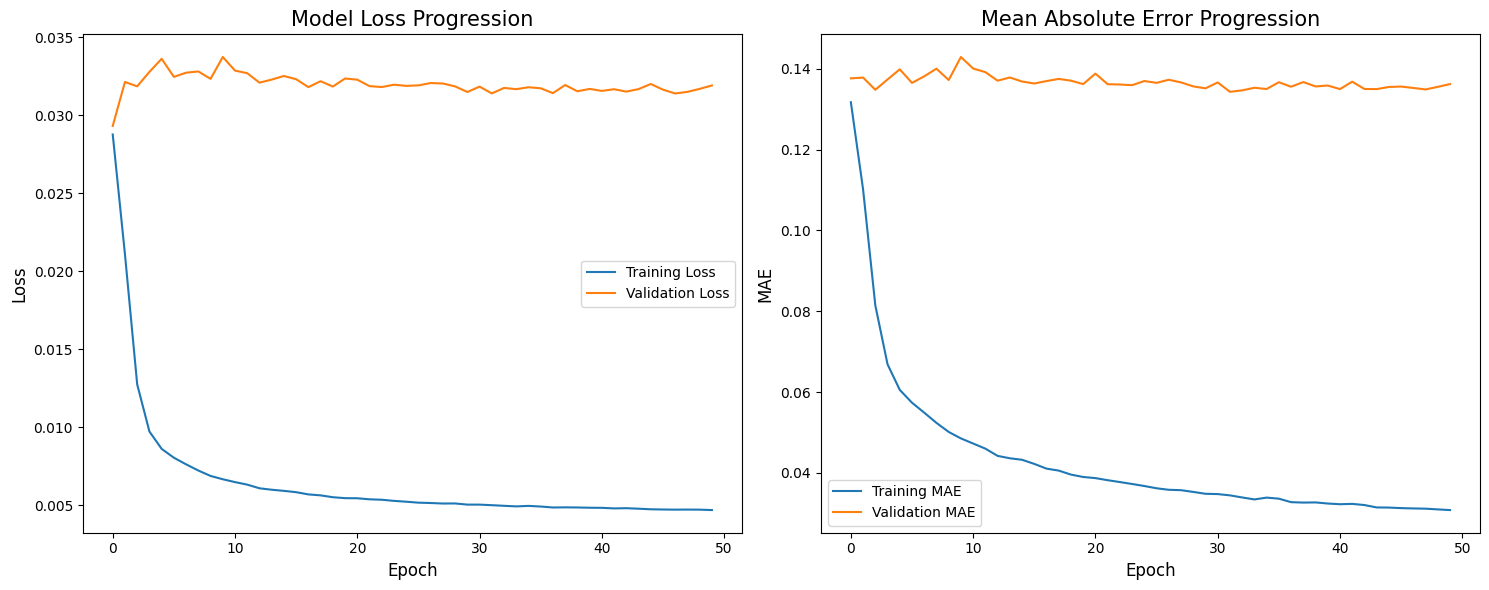

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))

# Loss Plot dengan style seaborn
plt.subplot(1, 2, 1)
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], label='Training Loss')
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression', fontsize=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()

# MAE Plot dengan style seaborn
plt.subplot(1, 2, 2)
sns.lineplot(x=range(len(history.history['mae'])), y=history.history['mae'], label='Training MAE')
sns.lineplot(x=range(len(history.history['val_mae'])), y=history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error Progression', fontsize=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

Hasil evaluasi menunjukkan dua grafik yang memvisualisasikan kinerja model pembelajaran mesin selama pelatihan.

Grafik pertama di sebelah kiri adalah `Model Loss Progression`, yang melacak kerugian pelatihan dan kerugian validasi selama periode pelatihan. Kerugian pelatihan dan kerugian validasi keduanya dimulai relatif tinggi dan kemudian terus menurun saat model dilatih.

Grafik kedua di sebelah kanan adalah `Mean Absolute Error Progression`, yang melacak kesalahan absolut rata-rata (MAE) untuk data pelatihan dan validasi selama periode pelatihan. Mirip dengan kerugian, MAE pelatihan dan MAE validasi dimulai lebih tinggi dan kemudian menurun saat model membaik.

Secara keseluruhan, grafik ini menunjukkan bahwa model belajar secara efektif, dengan kerugian dan MAE menurun secara konsisten selama proses pelatihan untuk data pelatihan dan validasi. Ini menunjukkan bahwa model tersebut digeneralisasi dengan baik dan tidak terlalu sesuai dengan data pelatihan.

### Inferensi

Menggunakan model yang sudah dilatih untuk memprediksi positive_ratio untuk 5 sampel game.

In [ ]:
# Prediksi positive ratio untuk beberapa game
sample_games = final_games.sample(5)

predicted_ratings = recommender_model.predict([
    tags_df.loc[sample_games.index].values,
    description_padded[sample_games.index],
    sample_games[['win', 'mac', 'linux', 'steam_deck']].values
])

sample_games['predicted_rating'] = predicted_ratings * 100
print(sample_games[['title', 'predicted_rating']])

1/1 [==============================] - 0s 96ms/step
                    title  predicted_rating
17801  Hardwork Simulator         90.796982
41968             Puzzler         93.153923
5222            Champs TD         81.697952
50477   Robots - Invaders         81.676636
1235             Sandmade         89.818069


# Kesimpulan